In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# Frequencies of Planck
HF = [100, 143, 217, 353, 545, 857] # [GHz]

In [3]:
# Get smooth values from PSF
R = fits.getdata("../Maps/Initial/HFI_RIMO_R2.00.fits", 2)
FWHM = R[:]["FWHM"]

In [4]:
# Create DataFrame with frequencies and FWHM
data = pd.DataFrame(data=[HF,FWHM]).T
data.columns = ["Frequency", "FWHM"]

In [5]:
# Getting the PSF map for each frequency
data["PSF Map"] = data["Frequency"].map(
    lambda x: hp.read_map(f"../Maps/Generated/HFI_{int(x)}.fits")
)

In [6]:
data

Frequency   FWHM                                            PSF Map
0      100.0  9.682  [-0.00011166872697597953, -6.739701333126776e-...
1      143.0  7.303  [-0.00010190161160085197, -4.5524963778931716e...
2      217.0  5.021  [-4.18147945553166e-05, 1.9249772073472454e-05...
3      353.0  4.944  [0.0004353593728396761, 0.00047781326454553554...
4      545.0  4.831  [0.007369400054964218, 0.007334221881925925, 0...
5      857.0  4.638  [0.3740405474049448, 0.37368126830176546, 0.37...

In [7]:
data["PSF Map"][0]

array([-1.11668727e-04, -6.73970133e-05, -1.31045166e-05, ...,
        1.00404637e-04,  9.25628878e-05,  1.03484091e-04])

In [8]:
# Get the covariance matrix for all maps
T = np.array(data["PSF Map"].to_list())
V = np.cov(T)
V

array([[2.39120103e-07, 2.14069150e-07, 7.47188879e-07, 5.12971090e-06,
        9.37313689e-05, 8.31413905e-03],
       [2.14069150e-07, 2.10854654e-07, 7.27468249e-07, 5.08773300e-06,
        9.15688679e-05, 7.96760586e-03],
       [7.47188879e-07, 7.27468249e-07, 2.71215280e-06, 1.91135638e-05,
        3.46288088e-04, 3.02569016e-02],
       [5.12971090e-06, 5.08773300e-06, 1.91135638e-05, 1.35723165e-04,
        2.45830343e-03, 2.14454618e-01],
       [9.37313689e-05, 9.15688679e-05, 3.46288088e-04, 2.45830343e-03,
        4.47502936e-02, 3.92446451e+00],
       [8.31413905e-03, 7.96760586e-03, 3.02569016e-02, 2.14454618e-01,
        3.92446451e+00, 3.46555057e+02]])

In [9]:
# Determine the CMB
S = np.divide(
        np.matmul(
            np.matmul(
                np.ones(V.shape[0]),
                np.linalg.inv(V)
            ),
            T
        ),
        np.matmul(
            np.matmul( np.ones(V.shape[0]), np.linalg.inv(V)),
            np.ones(V.shape[0])
        )
)

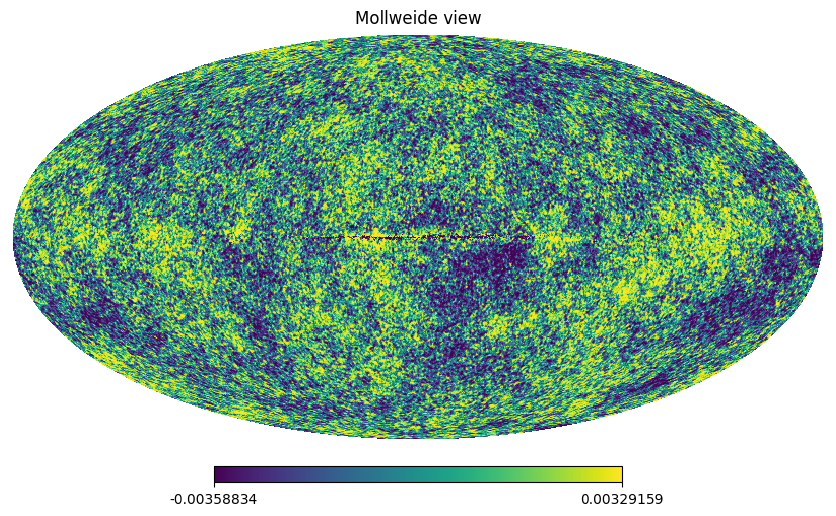

In [10]:
# Display view
hp.mollview(S, norm = "hist")

In [13]:
# Write map of CMB into a healpix FITS file.
hp.write_map(
        "../Maps/Generated/CMB.fits",
        S,
        overwrite=True
    )

setting the output map dtype to [dtype('float64')]


In [14]:
HFI_857 = hp.read_map(f"../Maps/Generated/HFI_857.fits")
mask = np.where( HFI_857<np.average(HFI_857), 1, 0)

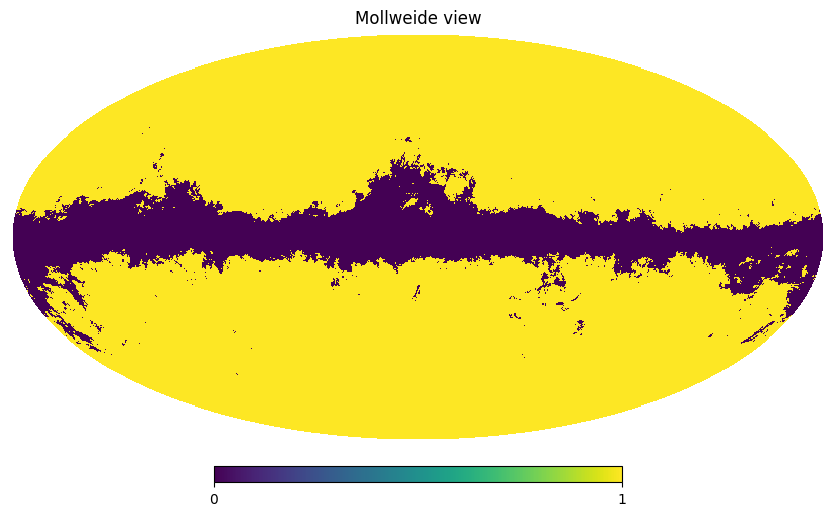

In [15]:
hp.mollview(mask, norm = "hist")

In [16]:
hp.write_map(
        "../Maps/Generated/mask.fits",
        mask,
        overwrite=True
    )

setting the output map dtype to [dtype('int64')]


In [17]:
Sm = S*mask

In [18]:
S_grade = hp.ud_grade( S, nside_out=2048)
Sm_grade = hp.ud_grade( Sm, nside_out=2048)

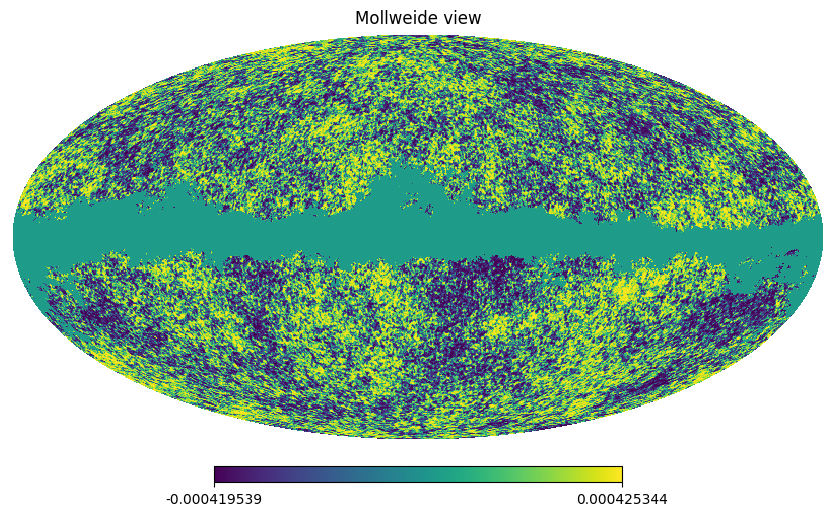

In [20]:
hp.mollview(Sm_grade, norm = "hist")

In [23]:
hp.write_map(
        "../Maps/Generated/CMB_masked.fits",
        Sm,
        overwrite=True
    )

setting the output map dtype to [dtype('float64')]


In [21]:
hp.write_map(
        "../Maps/Generated/CMB_2048.fits",
        S_grade,
        overwrite=True
    )

setting the output map dtype to [dtype('float64')]


In [22]:
hp.write_map(
        "../Maps/Generated/CMB_masked_2048.fits",
        Sm_grade,
        overwrite=True
    )

setting the output map dtype to [dtype('float64')]


In [24]:
SH_S = hp.anafast(S_grade)
SH_Sm = hp.anafast(Sm_grade)

In [26]:
l=np.arange(np.size(SH_S))
a_l=l*(l+1)/(2*np.pi)

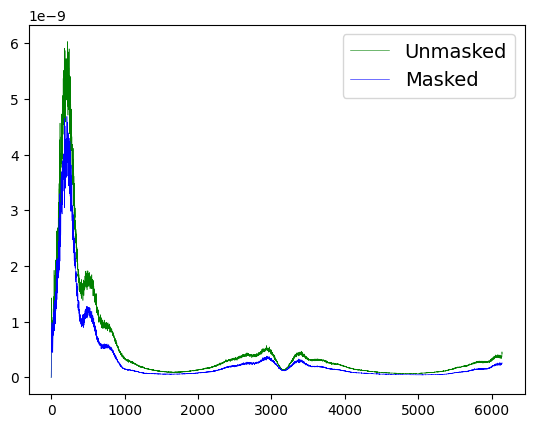

In [28]:
plt.figure()
plt.plot(l,a_l*SH_S,color="green", linewidth=0.4,label="Unmasked")
plt.plot(l,a_l*SH_Sm, color="blue", linewidth=0.4,label="Masked")
plt.legend(loc="upper right",fontsize=14)
plt.show()